In [31]:
from sentinelhub import WebFeatureService, BBox, CRS, DataSource

INSTANCE_ID = 'bd279917-8b23-4bc7-9a22-714214e86282'  # In case you put instance ID into cofniguration file

search_bbox = BBox(bbox=[13.6981099789, 45.4523163926, 16.5648083839, 46.8523859727], crs=CRS.WGS84)
search_time_interval = ('2017-07-01T00:00:00', '2017-07-05T23:59:59')


wfs_iterator = WebFeatureService(search_bbox, search_time_interval,
                                 data_source=DataSource.SENTINEL2_L1C,
                                 maxcc=1.0, instance_id=INSTANCE_ID)
flag = 1
first_tile_info = dict()
for tile_info in wfs_iterator:
    if (flag):
        flag = 0
        first_tile_info = tile_info
    print(tile_info)

{'type': 'Feature', 'geometry': {'type': 'MultiPolygon', 'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:EPSG::4326'}}, 'coordinates': [[[[13.685452604134886, 46.94615337572221], [15.128253781555603, 46.95362835043808], [15.125954377023676, 45.96549074129876], [13.70901256274414, 45.95826783285329], [13.685452604134886, 46.94615337572221]]]]}, 'properties': {'id': 'S2B_OPER_MSI_L1C_TL_SGS__20170705T135031_A001721_T33TVM_N02.05', 'date': '2017-07-05', 'time': '10:00:26', 'path': 's3://sentinel-s2-l1c/tiles/33/T/VM/2017/7/5/0', 'crs': 'EPSG:32633', 'mbr': '399960,5090220 509760,5200020', 'cloudCoverPercentage': 4.2}}
{'type': 'Feature', 'geometry': {'type': 'MultiPolygon', 'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:EPSG::4326'}}, 'coordinates': [[[[13.706964216648387, 46.046250757305785], [15.126154289792652, 46.05349574985211], [15.123961815690901, 45.06520172202316], [13.729428921330111, 45.058200811027135], [13.706964216648387, 46.046250757305785]]

In [20]:
data = wfs_iterator.get_tiles()
tile_name, time, aws_index = data[1]
print (data)

[('33TVM', '2017-7-5', 0), ('33TVL', '2017-7-5', 0), ('33TUL', '2017-7-5', 0), ('33TWL', '2017-7-5', 0), ('33TUM', '2017-7-5', 0), ('33TXM', '2017-7-5', 0), ('33TXL', '2017-7-5', 0), ('33TUM', '2017-7-3', 0), ('33TUL', '2017-7-3', 0), ('33TVM', '2017-7-3', 0), ('33TVL', '2017-7-3', 0), ('33TXL', '2017-7-2', 0), ('33TXM', '2017-7-2', 0), ('33TWL', '2017-7-2', 0), ('33TWM', '2017-7-2', 0), ('33TVL', '2017-7-2', 0)]


In [21]:
#загрузка tileinfo
#как достать tileinfo для всей словении
from sentinelhub import AwsTileRequest

bands = []
metafiles = ['tileInfo']
data_folder = './tile_inf'

request = AwsTileRequest(tile=tile_name, time=time, aws_index=aws_index,
                         bands=bands, metafiles=metafiles, data_folder=data_folder,
                         data_source=DataSource.SENTINEL2_L1C)

request.save_data()

In [2]:
# %reload_ext autoreload
%autoreload 2
%matplotlib inline


import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from multiprocessing import Pool
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from shapely.geometry import Polygon
import lightgbm as lgb
from sklearn.externals import joblib
from sklearn import metrics
from sklearn import preprocessing


import geopandas as gpd


from eolearn.core import EOTask, EOPatch, LinearWorkflow, EOWorkflow, FeatureType, Dependency, OverwritePermission, LoadFromDisk, SaveToDisk
from eolearn.io import S2L1CWCSInput
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector, AddValidDataMaskTask
from eolearn.geometry import VectorToRaster, PointSamplingTask
from eolearn.features import LinearInterpolation, SimpleFilterTask
from sentinelhub import BBoxSplitter, BBox, CRS, CustomUrlParam


import pickle
import sys
import os
import datetime
import itertools
from tqdm import tqdm_notebook as tqdm


Dimension of the area is 249870 x 171656 m2


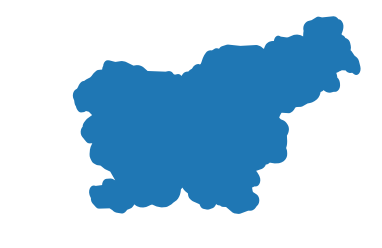

In [2]:
# Load geojson file

country = gpd.read_file('svn_buffered.geojson')

country_crs = CRS.UTM_33N
country = country.to_crs(crs={'init':CRS.ogc_string(country_crs)})

# Get the country's shape in polygon format
country_shape = country.geometry.values.tolist()[-1]

country.plot()
plt.axis('off');

 
print('Dimension of the area is {0:.0f} x {1:.0f} m2'.format(country_shape.bounds[2]-country_shape.bounds[0],country_shape.bounds[3]-country_shape.bounds[1]))

In [66]:
print(country_shape)

POLYGON ((372957.5520477997 5118057.360112497, 372745.4770910426 5118361.56925041, 372681.2035355614 5118456.047957221, 372673.4696774909 5118467.697131414, 372665.7230536059 5118479.365705286, 372055.9080980042 5119699.024982166, 371700.1990248558 5121115.654515178, 371368.7987909944 5123365.813471758, 371289.0083121675 5123629.487000763, 370964.23957322 5124266.940839025, 370430.3459746672 5125747.477715124, 370230.5261411405 5127397.375001258, 370382.7855244938 5129065.825877247, 370872.9366927422 5130600.384462536, 371655.9936113121 5131860.889586269, 372660.3523923566 5132732.248298831, 373845.0296358017 5133438.2812349, 374541.4256763434 5134581.339324228, 375478.6964216814 5136607.229136389, 376297.3460566331 5137893.915928484, 377152.0452015746 5138878.966676527, 378187.3413356951 5139737.186000144, 379349.4448866673 5140102.918893992, 379883.0891955853 5140149.506193068, 380118.6533168997 5140258.731625173, 381739.6793070178 5141395.115445548, 382140.8637200701 5141637.5995129

In [3]:
use_smaller_patches = True

bbox_splitter_large = BBoxSplitter([country_shape], country_crs, (25, 17))
bbox_splitter_small = BBoxSplitter([country_shape], country_crs, (25*3, 17*3))

bbox_splitter = bbox_splitter_small if use_smaller_patches else bbox_splitter_large

bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())

# Select a central patch
ID = 1549 if use_smaller_patches else 190 # Reference map provided only for this area


patchIDs = []

for idx, [bbox, info] in enumerate(zip(bbox_list, info_list)):
    if (abs(info['index_x'] - info_list[ID]['index_x']) <= 1 and
        abs(info['index_y'] - info_list[ID]['index_y']) <= 1):
        patchIDs.append(idx)

# Check if final size is 3x3
if len(patchIDs) != 9:
    print('Warning! Use a different central patch ID, this one is on the border.')
    
# Change the order of the patches (used for plotting later)
patchIDs = np.transpose(np.fliplr(np.array(patchIDs).reshape(3,3))).ravel()
    
# Prepare info of selected EOPatches
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list[patchIDs]]
idxs_x = [info['index_x'] for info in info_list[patchIDs]]
idxs_y = [info['index_y'] for info in info_list[patchIDs]]
df = pd.DataFrame({'index_x':idxs_x, 'index_y':idxs_y})
gdf = gpd.GeoDataFrame(df, 
                       crs={'init':CRS.ogc_string(country_crs)}, 
                       geometry=geometry)

In [4]:
print(gdf)

   index_x  index_y                                           geometry
0       42       29  POLYGON ((510157.6172221425 5122327.229129893,...
1       43       29  POLYGON ((513489.214628833 5122327.229129893, ...
2       44       29  POLYGON ((516820.8120355235 5122327.229129893,...
3       42       28  POLYGON ((510157.6172221425 5118961.421479214,...
4       43       28  POLYGON ((513489.214628833 5118961.421479214, ...
5       44       28  POLYGON ((516820.8120355235 5118961.421479214,...
6       42       27  POLYGON ((510157.6172221425 5115595.613828535,...
7       43       27  POLYGON ((513489.214628833 5115595.613828535, ...
8       44       27  POLYGON ((516820.8120355235 5115595.613828535,...


In [5]:
poly = gdf['geometry'][0]
x1,y1,x2,y2 = poly.bounds
aspect_ratio = (y1-y2)/(x1-x2)

(357737.03586605104, 632593.8219180192, 5016135.9977509845, 5204957.80695405)

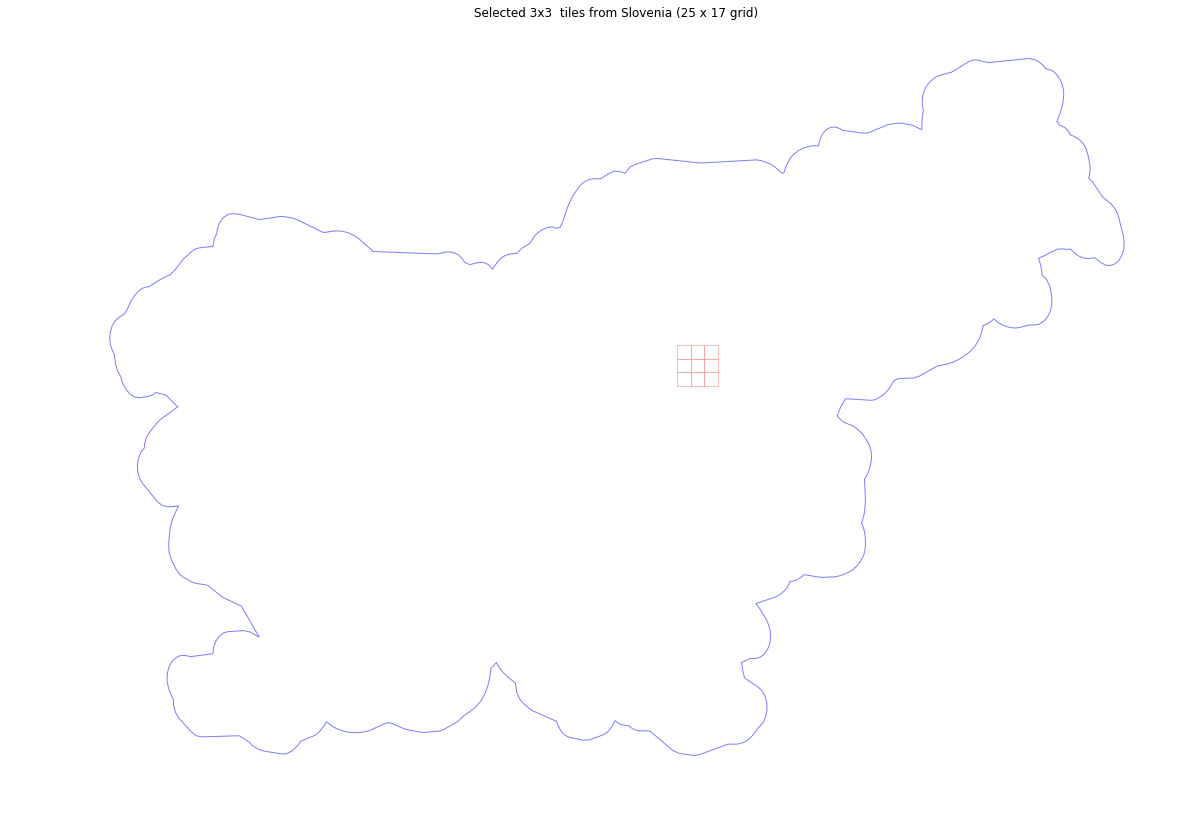

In [6]:
fontdict = {'family': 'monospace', 'weight': 'normal', 'size': 11}

xl, yl, xu, yu = gdf.geometry[0].bounds
xoff, yoff = (xu-xl)/3, (yu-yl)/5

fig, ax = plt.subplots(figsize=(20,20))
gdf.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.5)
country.plot(ax=ax, facecolor='w',edgecolor='b',alpha=0.5)
ax.set_title('Selected 3x3  tiles from Slovenia (25 x 17 grid)');
plt.axis('off')

In [7]:
class SentinelHubValidData:
   
    def __call__(self, eopatch):        
        return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool), 
                              np.logical_not(eopatch.mask['CLM'].astype(np.bool)))
    
class CountValid(EOTask):   
  
    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name
        
    def execute(self, eopatch):
        eopatch.add_feature(FeatureType.MASK_TIMELESS, self.name, np.count_nonzero(eopatch.mask[self.what],axis=0))
        
        return eopatch


class NormalizedDifferenceIndex(EOTask):   
   
    def __init__(self, feature_name, band_a, band_b):
        self.feature_name=feature_name
        self.band_a_fetaure_name=band_a.split('/')[0]
        self.band_b_fetaure_name=band_b.split('/')[0]
        self.band_a_fetaure_idx=int(band_a.split('/')[-1])
        self.band_b_fetaure_idx=int(band_b.split('/')[-1])
        
    def execute(self, eopatch):
        band_a = eopatch.data[self.band_a_fetaure_name][..., self.band_a_fetaure_idx]
        band_b = eopatch.data[self.band_b_fetaure_name][..., self.band_b_fetaure_idx]
        
        ndi = (band_a-band_b)/(band_a+band_b)
        
        eopatch.add_feature(FeatureType.DATA, self.feature_name, ndi[...,np.newaxis])
        
        return eopatch

    
class EuclideanNorm(EOTask):   

    def __init__(self, feature_name, in_feature_name):
        self.feature_name=feature_name
        self.in_feature_name=in_feature_name
    
    def execute(self, eopatch):
        arr = eopatch.data[self.in_feature_name]
        norm = np.sqrt(np.sum(arr**2, axis=-1))
        
        eopatch.add_feature(FeatureType.DATA, self.feature_name, norm[...,np.newaxis])
        return eopatch

In [3]:
import sys
!conda install --yes --prefix {sys.prefix} -c conda-forge lightgbm

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.9
  latest version: 4.6.8

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/jana/anaconda

  added / updated specs: 
    - lightgbm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    libblas-3.8.0              |       4_openblas           6 KB  conda-forge
    openblas-0.3.5             |    h436c29b_1001        17.5 MB  conda-forge
    clangdev-4.0.0             |        default_0        62.8 MB  conda-forge
    libcblas-3.8.0             |       4_openblas           6 KB  conda-forge
    lightgbm-2.2.2             |   py36h0a44026_0         637 KB  conda-forge
    cryptography-2.6.1         |   py36hc2b1221_0         563 KB  conda-forge
    scipy-1.2.1                |   py36hbd7caa9_1        15.7 MB  conda

In [8]:

save_choice = True  

# TASK FOR BAND DATA
custom_script = 'return [B02, B03, B04, B08, B11, B12];'
add_data = S2L1CWCSInput(
    layer='BANDS-S2-L1C', 
    feature=(FeatureType.DATA, 'BANDS'),
    custom_url_params={CustomUrlParam.EVALSCRIPT: custom_script},
    resx='10m', # resolution x
    resy='10m', # resolution y
    maxcc=0.8, # maximum allowed cloud cover of original ESA tiles
)

# TASK FOR CLOUD INFO
cloud_classifier = get_s2_pixel_cloud_detector(average_over=2, dilation_size=1, all_bands=False)
add_clm = AddCloudMaskTask(cloud_classifier, 'BANDS-S2CLOUDLESS', cm_size_y='160m', cm_size_x='160m', 
                           cmask_feature='CLM',
                           cprobs_feature='CLP'
                          )

# TASKS FOR CALCULATING NEW FEATURES
# NDVI: (B08 - B04)/(B08 + B04)
# NDWI: (B03 - B08)/(B03 + B08)
# NORM: sqrt(B02^2 + B03^2 + B04^2 + B08^2 + B11^2 + B12^2)
ndvi = NormalizedDifferenceIndex('NDVI', 'BANDS/3', 'BANDS/2')
ndwi = NormalizedDifferenceIndex('NDWI', 'BANDS/1', 'BANDS/3')
norm = EuclideanNorm('NORM','BANDS')

# TASK FOR VALID MASK 
add_sh_valmask = AddValidDataMaskTask(SentinelHubValidData(), 
                                      'IS_VALID' # name of output mask
                                     )

# TASK FOR COUNTING VALID PIXELS
count_val_sh = CountValid('IS_VALID', # name of existing mask
                          'VALID_COUNT'
                         )

# TASK FOR SAVING TO OUTPUT (if needed)
path_out = './eopatches_small/'
if not os.path.isdir(path_out) and save_choice:
    os.makedirs(path_out)
save = SaveToDisk(path_out, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

In [9]:
raba_path = 'raba_small/raba_subset_small.shp'

raba = gpd.read_file(raba_path)

raba_val = [0,1,2,3,4,5,6,7,8,9,10]
raba_array = []
for val in raba_val:
    temp = raba[raba.lulcid==val]
    temp.reset_index(drop=True, inplace=True)
    raba_array.append(temp)
    del temp
    
rshape = (FeatureType.MASK, 'IS_VALID')

raba_task_array = []
for el, val in zip(raba_array, raba_val):
    raba_task_array.append(VectorToRaster(
        feature=(FeatureType.MASK_TIMELESS, 'LULC'), 
        vector_data=el,
        raster_value=val, 
        raster_shape=rshape,
        raster_dtype=np.uint8))

In [11]:
if save_choice:
    save_task = [save]
else:
    save_task = []

# Define the workflow
workflow = LinearWorkflow(
    add_data,
    add_clm,
    ndvi,
    ndwi,
    norm,
    add_sh_valmask,
    count_val_sh,
    *raba_task_array,
    *save_task
)

In [12]:
%%time

# Execute the workflow
eopatches = [] # container for the full eopatches
time_interval = ['2017-01-01','2017-12-31'] # time interval for request

pbar = tqdm(total=len(patchIDs))
for idx, bbox in enumerate(bbox_list[patchIDs]):
    # define additional parameters of the workflow
    extra_param = {add_data:{'bbox':bbox, 'time_interval':time_interval}}
    if save_choice:
        extra_param[save] = {'eopatch_folder': 'eopatch_{}'.format(idx)}
    
    result = workflow.execute(extra_param)    
    if save_choice:
        del result
    else:
        eopatches.append(result[list(result.keys())[-1]])
    pbar.update(1)

CPU times: user 1min 45s, sys: 21.2 s, total: 2min 6s
Wall time: 6min 4s


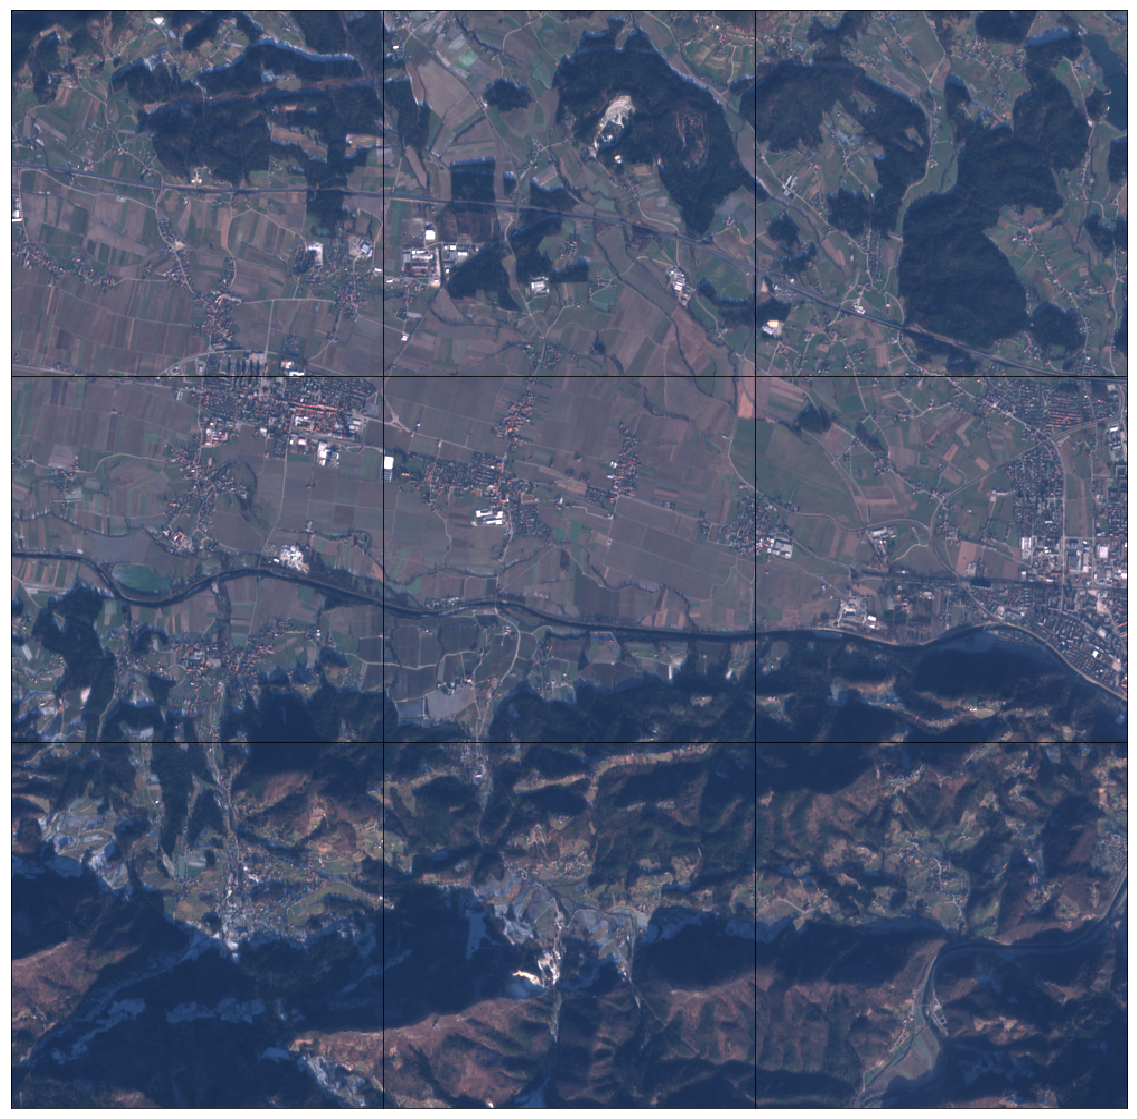

In [13]:
# Draw the RGB image
path_out = './eopatches_small/' if use_smaller_patches else './eopatches_large/'
fig = plt.figure(figsize=(20,20*aspect_ratio))

pbar = tqdm(total=9)
for i in range(9):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, i)) if save_choice else eopatches[i]
    ax = plt.subplot(3,3,i+1)
    plt.imshow(np.clip(eopatch.data['BANDS'][0][...,[2,1,0]]*3.5,0,1))
    plt.xticks([])
    plt.yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

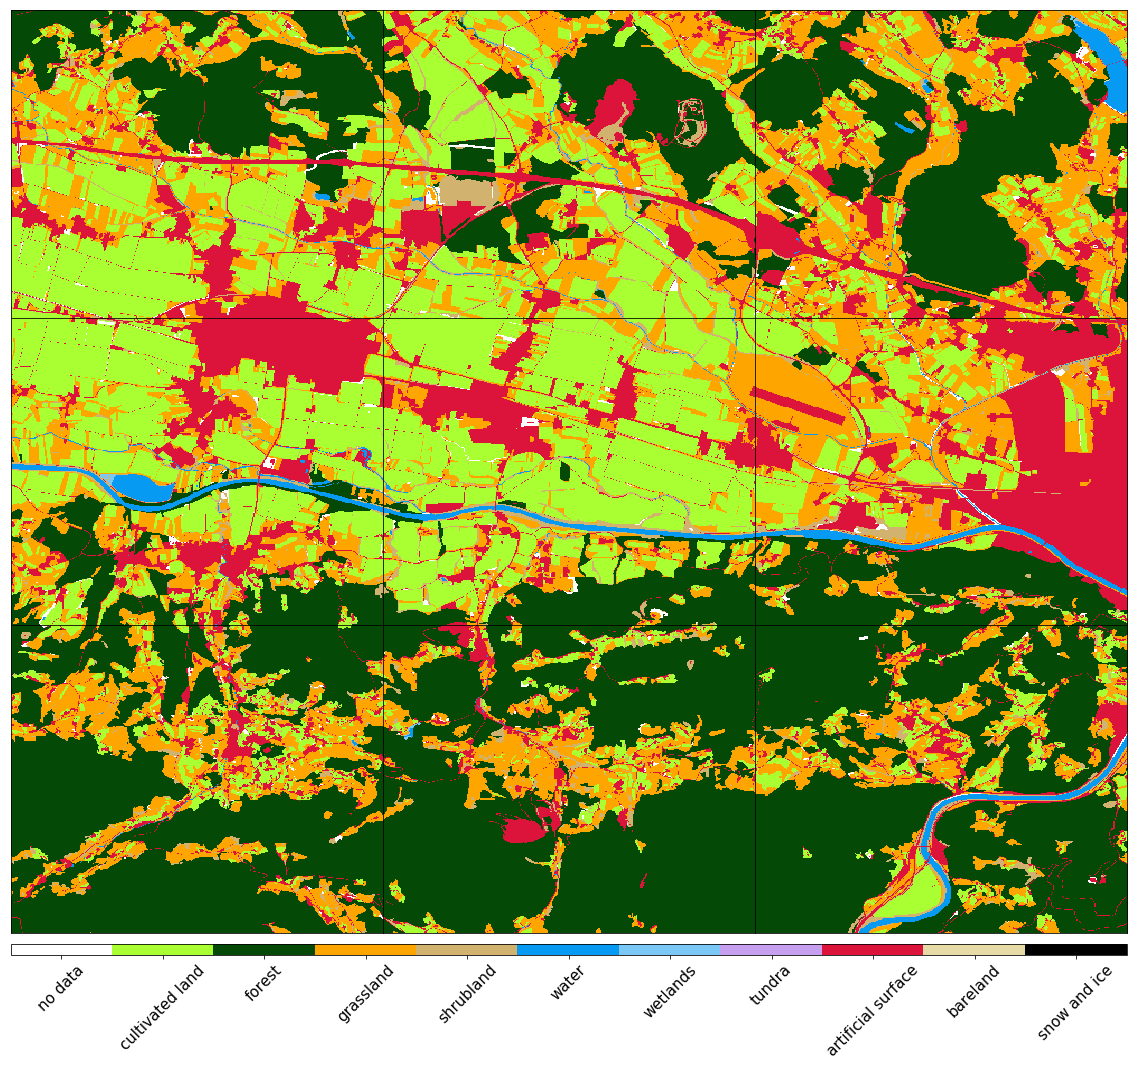

In [14]:
path_out = './eopatches_small/'

# Reference colormap
sys.path.append('../../example_data/')
from lulc_cmap import lulc_cmap, lulc_norm
from lulc_classes import lulc_classes

fig, axes = plt.subplots(figsize=(20,20*aspect_ratio), nrows=3, ncols=3)

pbar = tqdm(total=9)
for i, ax in enumerate(axes.flat):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, i)) if save_choice else eopatches[i]
    im = ax.imshow(eopatch.mask_timeless['LULC'].squeeze(), cmap=lulc_cmap, norm=lulc_norm)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', pad = 0.01, aspect=100)
cb.ax.tick_params(labelsize=20) 
cb.set_ticks(np.array(list(lulc_classes.values())))
cb.ax.set_xticklabels(list(lulc_classes.keys()),rotation=45,fontsize=15)
plt.show()


• lulcid=0,  name=nodata
• lulcid = 1, name = cultivated land 
• lulcid = 2, name = forest
• lulcid = 3, name = grassland
• lulcid = 4, name = shrubland
• lulcid = 5, name = water
• lulcid = 6, name = wetlands
• lulcid = 7, name = tundra
• lulcid = 8, name = artificial surface • lulcid = 9, name = bareland
• lulcid = 10, name = snow and ice

In [ ]:
#slovenia coordinates
(13.6981099789, 45.4523163926, 16.5648083839, 46.8523859727)

In [15]:
class LoadFromMemory(EOTask):
    
    def execute(self, eopatch):
        return eopatch
    

class ConcatenateData(EOTask):
    """ 
        Task to concatenate data arrays along the last dimension
    """
    def __init__(self, feature_name, feature_names_to_concatenate):
        self.feature_name = feature_name
        self.feature_names_to_concatenate = feature_names_to_concatenate

    def execute(self, eopatch):
        arrays = [eopatch.data[name] for name in self.feature_names_to_concatenate]

        eopatch.add_feature(FeatureType.DATA, self.feature_name, np.concatenate(arrays, axis=-1))

        return eopatch
    
    
class ValidDataFractionPredicate:
  
    def __init__(self, threshold):
        self.threshold = threshold
        
    def __call__(self, array):
        coverage = np.sum(array.astype(np.uint8))/np.prod(array.shape)
        return coverage > self.threshold    
    
    
class MoveFeature(EOTask):
    """
    Task to copy fields from one eopatch to another
    """
    def __init__(self, fields_to_copy):
        self.fields_to_copy = fields_to_copy
        
    def execute(self, *eopatches):
        dst_eopatch, src_eopatch = eopatches
        for key in self.fields_to_copy.keys():
            for name in self.fields_to_copy[key]:
                dst_eopatch.add_feature(key, name, src_eopatch[key][name])
        return dst_eopatch

In [22]:
# TASK TO LOAD EXISTING EOPATCHES
load_from_file = LoadFromDisk(path_out, lazy_loading = True)
load_from_memory = LoadFromMemory()

# TASK FOR CONCATENATION
concatenate = ConcatenateData('FEATURES', ['BANDS', 'NDVI', 'NDWI', 'NORM'])

# TASK FOR FILTERING OUT TOO CLOUDY SCENES
# keep frames with > 80 % valid coverage
valid_data_predicate = ValidDataFractionPredicate(0.8)
filter_task = SimpleFilterTask((FeatureType.MASK, 'IS_VALID'), valid_data_predicate)

# TASK FOR LINEAR INTERPOLATION
resampled_range = ('2017-01-01','2017-12-31',16)
linear_interp = LinearInterpolation(
    'FEATURES',
    mask_feature = (FeatureType.MASK,'IS_VALID'), # mask to be used in interpolation
    resample_range=resampled_range, # set the resampling range
    bounds_error=False
)

move_features = MoveFeature({
    FeatureType.MASK_TIMELESS: {'LULC'},
    FeatureType.MASK: {'IS_VALID'}
})

# Uniformly sample about 100k pixels from patches
n_samples = int(4e4)
ref_labels = [0,1,2,3,4,5,6,7,8,9,10] # reference labels to take into account when sampling
disk_radius = 1
spatial_sampling = PointSamplingTask(
    n_samples=n_samples, 
    ref_mask_feature='LULC', 
    ref_labels=ref_labels, 
    sample_features=[
        (FeatureType.DATA, 'FEATURES'), 
        (FeatureType.MASK, 'IS_VALID'),
        (FeatureType.MASK_TIMELESS, 'LULC')])

path_out_sampled = './eopatches_sampled_small/'
if not os.path.isdir(path_out_sampled) and save_choice:
    os.makedirs(path_out_sampled)
save = SaveToDisk(path_out_sampled, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

In [23]:
if save_choice:
    load = load_from_file
    save_dependency = [Dependency(task=save, inputs=[spatial_sampling])]
else:
    load = load_from_memory
    save_dependency = []

workflow = EOWorkflow(dependencies=[
    Dependency(task=load, inputs=[]),
    Dependency(task=concatenate, inputs=[load]),
    Dependency(task=filter_task, inputs=[concatenate]),
    Dependency(task=linear_interp, inputs=[filter_task]),
    Dependency(task=move_features, inputs=[linear_interp, filter_task]),
    Dependency(task=spatial_sampling, inputs=[move_features]),
    *save_dependency
])

In [24]:
%%time
disk_radius = 1
pbar = tqdm(total=len(patchIDs))
for i in range(9):
    if save_choice:
        result = workflow.execute({
            load: {'eopatch_folder': 'eopatch_{}'.format(i)},
            save: {'eopatch_folder': 'eopatch_{}'.format(i)}
        })
        del result
    else:
        result = workflow.execute({
            load: {'eopatch': eopatches[i]}
        })
        eopatches[i] = result[list(result.keys())[-1]]
        del result
    pbar.update(1)


CPU times: user 4min, sys: 20.9 s, total: 4min 21s
Wall time: 4min 24s


In [25]:
if save_choice:
    # load sampled eopatches
    eopatches = []
    path_out_sampled = './eopatches_sampled_small/'
    
    for i in range(9):
        eopatches.append(EOPatch.load('{}/eopatch_{}'.format(path_out_sampled, i), lazy_loading = True))    

eopatches = np.array(eopatches)

In [26]:
# Definition of the train and test patch IDs
train_ID = [0,2,3,4,5,6,7,8] if use_smaller_patches else [0,1,3,4,5,6,7,8]
test_ID = [1] if use_smaller_patches else [2]

# Set the features and the labels for train and test sets
features_train = np.array([eopatch.data['FEATURES_SAMPLED'] for eopatch in eopatches[train_ID]])
labels_train = np.array([eopatch.mask_timeless['LULC_SAMPLED'] for eopatch in eopatches[train_ID]])
features_test = np.array([eopatch.data['FEATURES_SAMPLED'] for eopatch in eopatches[test_ID]])
labels_test = np.array([eopatch.mask_timeless['LULC_SAMPLED'] for eopatch in eopatches[test_ID]])

# rotate dimension so that reshape can be used 
p1, t, w, h, f = features_train.shape
p2, t, w, h, f = features_test.shape
p = p1+p2

# reshape to n x m
features_train = np.swapaxes(features_train,1,3).reshape(p1*h*w, t*f)
labels_train = np.swapaxes(labels_train,1,2).reshape(p1*h*w,1).squeeze()
features_test = np.swapaxes(features_test,1,3).reshape(p2*h*w, t*f)
labels_test = np.swapaxes(labels_test,1,2).reshape(p2*h*w,1).squeeze()

# remove points with no reference from training (so we dont train to recognize "no data")
mask = labels_train == 0
features_train = features_train[~mask]
labels_train = labels_train[~mask]

# remove points with no reference from test (so we dont validate on "no data", which doesn't make sense)
mask = labels_test == 0
features_test = features_test[~mask]
labels_test = labels_test[~mask]

In [27]:
%%time

# Set up training classes
labels_unique = np.unique(labels_train)

# Set up the model
model = lgb.LGBMClassifier(objective='multiclass', 
    num_class=len(labels_unique), metric='multi_logloss)

model.fit(features_train, labels_train)

model_base = 'model_SI_LULC_smaller'
joblib.dump(model, './{}_{}.pkl'.format(model_base, datetime.date.today().strftime("%m.%d.%Y")))

CPU times: user 6min 16s, sys: 1.32 s, total: 6min 17s
Wall time: 1min 39s


In [29]:

model_path = './model_SI_LULC_smaller_03.22.2019.pkl'
model = joblib.load(model_path)

plabels_test = model.predict(features_test)

In [30]:
print('Classification accuracy {:.1f}%'.format(100*metrics.accuracy_score(labels_test, plabels_test)))
print('Classification F1-score {:.1f}%'.format(100*metrics.f1_score(labels_test, plabels_test, average='weighted')))

Classification accuracy 81.9%
Classification F1-score 81.4%


In [33]:
class_labels = np.unique(labels_test)
class_names = list(lulc_classes.keys())

f1_scores = metrics.f1_score(labels_test, plabels_test, labels=class_labels, average=None)
recall = metrics.recall_score(labels_test, plabels_test, labels=class_labels, average=None)
precision = metrics.precision_score(labels_test, plabels_test, labels=class_labels, average=None) 

print('             Class              =  F1  | Recall | Precision')
print('         --------------------------------------------------')
for idx, lulctype in enumerate([class_names[idx] for idx in class_labels]):
    print('         * {0:20s} = {1:2.1f} |  {2:2.1f}  | {3:2.1f}'.format(lulctype, 
                                                                         f1_scores[idx]*100, 
                                                                         recall[idx]*100, 
                                                                         precision[idx]*100))


             Class              =  F1  | Recall | Precision
         --------------------------------------------------
         * cultivated land      = 85.9 |  82.6  | 89.5
         * forest               = 91.2 |  94.3  | 88.4
         * grassland            = 78.3 |  83.0  | 74.2
         * shrubland            = 39.6 |  30.3  | 57.1
         * water                = 8.7 |  6.9  | 11.7
         * artificial surface   = 77.4 |  80.4  | 74.7


In [34]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, ylabel='True label',xlabel='Predicted label',filename=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2, suppress=True)
    
    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + np.finfo(np.float).eps)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    plt.title(title, fontsize=20)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

    plt.tight_layout()
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)

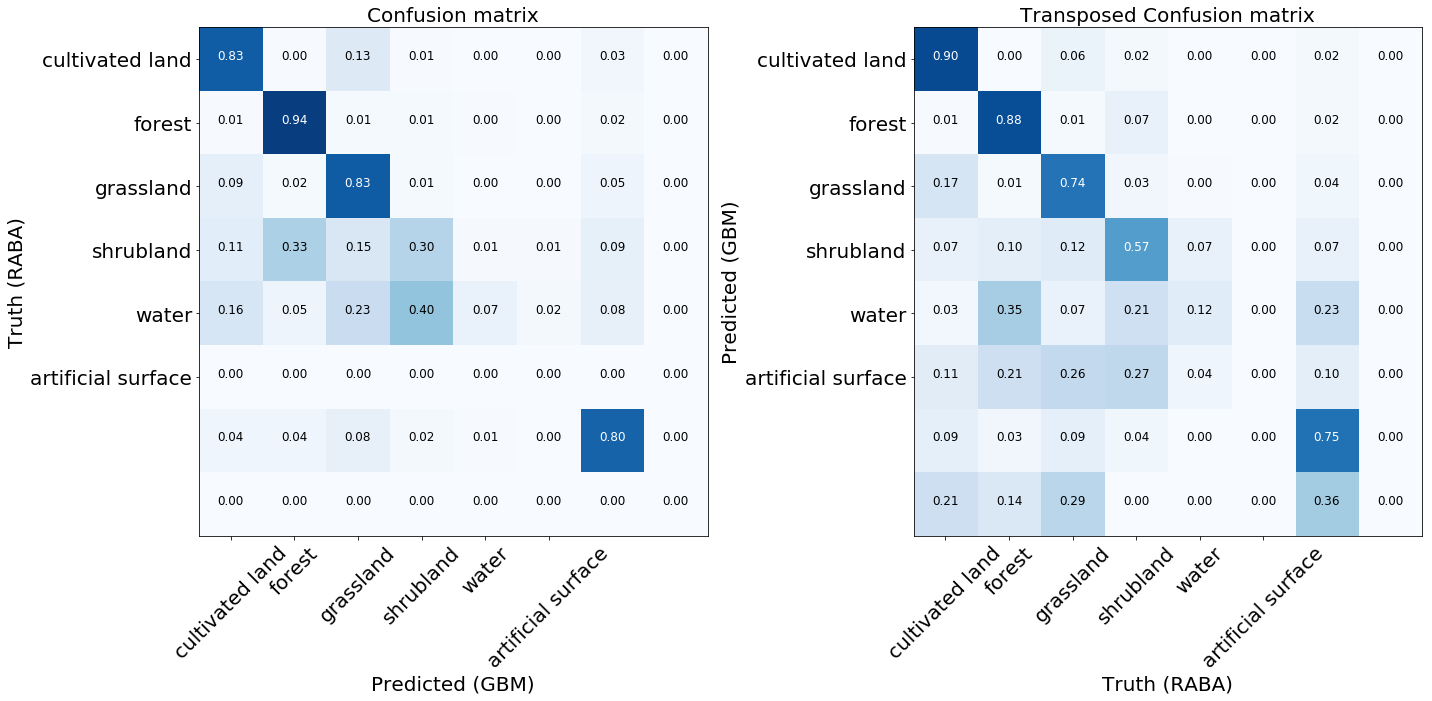

In [35]:
fig = plt.figure(figsize=(20,20))

plt.subplot(1,2,1)
conf_matrix_gbm = metrics.confusion_matrix(labels_test, plabels_test)
plot_confusion_matrix(conf_matrix_gbm, 
                      classes=[name for idx, name in enumerate(class_names) if idx in class_labels], 
                      normalize=True, 
                      ylabel='Truth (RABA)', 
                      xlabel='Predicted (GBM)',
                      title='Confusion matrix');

plt.subplot(1,2,2)
conf_matrix_gbm = metrics.confusion_matrix(plabels_test, labels_test)
plot_confusion_matrix(conf_matrix_gbm, 
                      classes=[name for idx, name in enumerate(class_names) if idx in class_labels], 
                      normalize=True, 
                      xlabel='Truth (RABA)', 
                      ylabel='Predicted (GBM)',
                      title='Transposed Confusion matrix');

plt.tight_layout()

In [ ]:
# Load geojson file

country = gpd.read_file('svn_buffered.geojson')

country_crs = CRS.UTM_33N
country = country.to_crs(crs={'init':CRS.ogc_string(country_crs)})

# Get the country's shape in polygon format
country_shape = country.geometry.values.tolist()[-1]

country.plot()
plt.axis('off');

 
print('Dimension of the area is {0:.0f} x {1:.0f} m2'.format(country_shape.bounds[2]-country_shape.bounds[0],country_shape.bounds[3]-country_shape.bounds[1]))